# Experiments

Run this notebook to reproduce the experiments from the paper.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler
# %load_ext cython

In [3]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets_morten import sample_circle, sample_rectangle, sample_torus, sample_cube, sample_flat_torus, sample_sphere
import warnings
import os
warnings.filterwarnings('ignore')

## Experiment configuration

Specify the number of points to sample, standard deviation for the perturbations and values of $k_\text{max}$ to use here.

In [6]:
N = 20000
M = 10000
sigma = 0.07
max_ks = [1, 10, 100, 1000]

In [7]:
path = 'results_M' + str(M) + '_N' + str(N) + '_sigma' + str(sigma)
if not os.path.exists(path):
    os.makedirs(path)

## Function definitions

### Compute distances to k-nearest neighbors in X

In [8]:
def k_nearest_neighbor_distances(X, k):
    kd_tree = KDTree(X)
    k_core_distances, _ = kd_tree.query(X, k=k, workers=-1)
    return k_core_distances  

### Compute filtration values of faces from squared radius and core values

In [9]:
def core_value(face, squared_radius, core_values):
    max_core = max(core_values[face]) 
    return max(squared_radius ** 0.5, max_core)

### Compute core value for each points

In [10]:
def vertex_values(X, max_k, max_r):
    if max_r is None or max_k <= 1:
        return k_nearest_neighbor_distances(X, k=[max_k])
    k_core_distances = k_nearest_neighbor_distances(X, np.arange(1, max_k + 1))
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        indices = np.argmax(line <= k_core_distances, axis=1)
        values = k_core_distances[np.arange(len(k_core_distances)), indices]
        values[values > max_r] = max_r
    else:
        values = np.array(k_core_distances)
    return values

### Compute core simplex tree from a simplex tree filtered by squared radius and a point cloud

In [11]:
def core_complex(X, st, max_k, max_r=None):
    k_core_distances = vertex_values(X, max_k, max_r)**2
    for vertex in range(X.shape[0]):
        st.assign_filtration([vertex], k_core_distances[vertex])
    st.make_filtration_non_decreasing()
    return st

### Compute simplex tree of a point cloud filtered by squared radius

In [12]:
def cech_squared_radius(X, max_dim=1):
    st = gudhi.SimplexTree()
    for dim in range(max_dim+1):
        for face in combinations(range(len(X)),dim+1):
            val = Miniball(X[list(face)]).squared_radius()
            st.insert(face, val)
    return st

### Construct core cech simplex tree

In [13]:
def core_cech(X, max_k=10, max_r=None, max_dim=1):
    st = cech_squared_radius(X, max_dim=max_dim)
    return core_complex(X, st, max_k, max_r)

### Construct core alpha simplex tree

In [14]:
def core_alpha(X, max_k=10, max_r=None, precision='safe'):
    st = gudhi.AlphaComplex(points=X, precision=precision).create_simplex_tree()
    return core_complex(X, st, max_k, max_r)

In [15]:
def sqrt_persistence(st):
    persistence = st.persistence()
    return [(dim, (birth**.5, death**.5)) for dim, (birth, death) in persistence]

In [16]:
def plot_sqrt_persistence(st, axes=None):
    return gudhi.plot_persistence_diagram(sqrt_persistence(st), axes=axes)

In [17]:
def persistence_intervals_in_dimension(persistence, dim):
    return np.array([(b, d) for dimension, (b, d) in persistence if dimension == dim])    

In [18]:
def persistence_diagrams(
    X, max_ks: list[int] = [1, 10, 100, 1000], 
    max_r: float | None = None
) -> list[tuple[int, tuple[int, int]]]:
    res = []
    for i, max_k in enumerate(max_ks):
        st = core_alpha(X, max_k=max_k, max_r=max_r)
        persistence = sqrt_persistence(st)
        res.append(persistence)
    return res

In [19]:
def bottleneck_distances(pers1, pers2, dim):
    assert len(pers1) == len(pers2)
    n = len(pers1)
    A = np.zeros(n)
    for i in range(n):
        a = persistence_intervals_in_dimension(pers1[i], dim)
        b = persistence_intervals_in_dimension(pers2[i], dim)
        bdist = gudhi.bottleneck_distance(a, b)
        A[i] = bdist
    return A

In [20]:
def plot_persistence_diagrams(pers_diagrams, max_ks, max_r, title="Alpha Čech"):
    fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
    fig.suptitle(title)
    for i, (pers, max_k) in enumerate(zip(pers_diagrams, max_ks)):
        gudhi.plot_persistence_diagram(pers, axes=axs[i])
        # st_core = core_cech(X, max_dim=2, max_k=max_k, max_r=max_r)
        # plot_sqrt_persistence(st_core, axes=axs[i])
        # gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
        axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
    fig.tight_layout()
    return fig    

# Circle

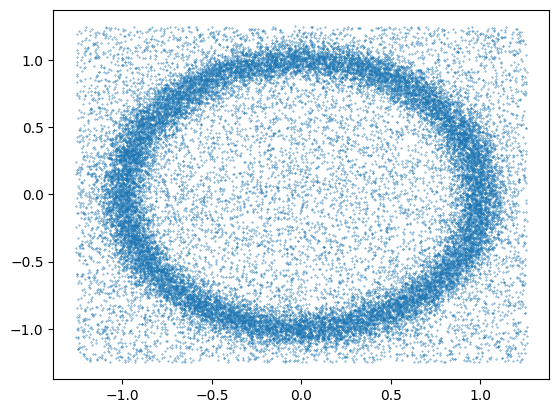

In [21]:
rng = np.random.default_rng(seed=0)
Z = sample_circle(N, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=0.1)
plt.show()

In [22]:
%%time
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

CPU times: user 4.79 s, sys: 69.7 ms, total: 4.86 s
Wall time: 2.74 s


In [23]:
X = sample_circle(M + N, rng, std=0)

In [24]:
pers_ideal = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

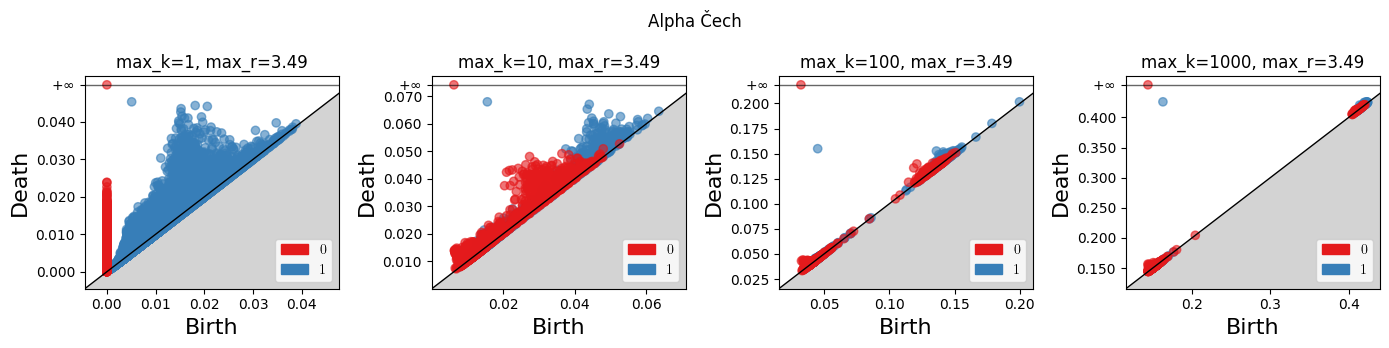

In [25]:
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

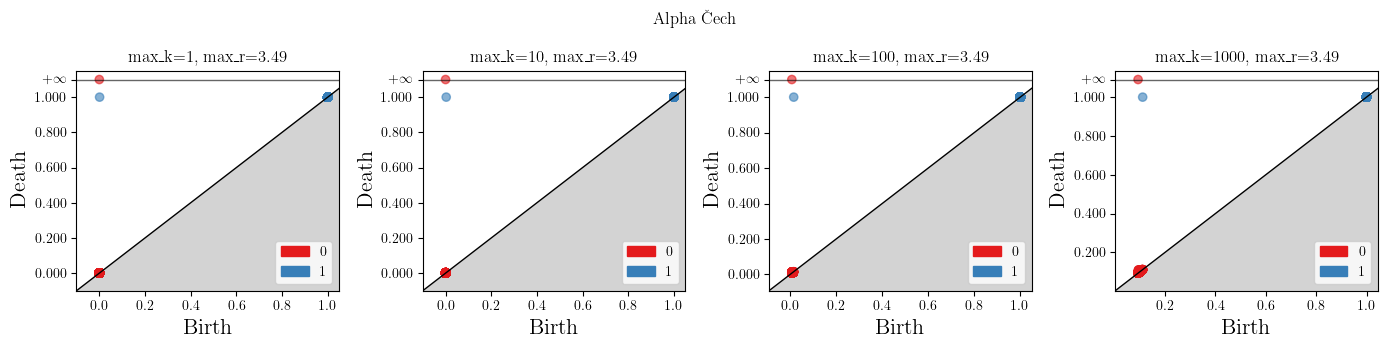

In [26]:
fig = plot_persistence_diagrams(pers_ideal, max_ks, max_r)

In [27]:
for dim in [0, 1]:
    np.savetxt(path + '/circle_'  + 'dim' + str(dim) + '.csv', 
            bottleneck_distances(pers_ideal, pers_diagrams, dim=dim)[None, :],
              delimiter='&',
              fmt="%.3f")

## Circles

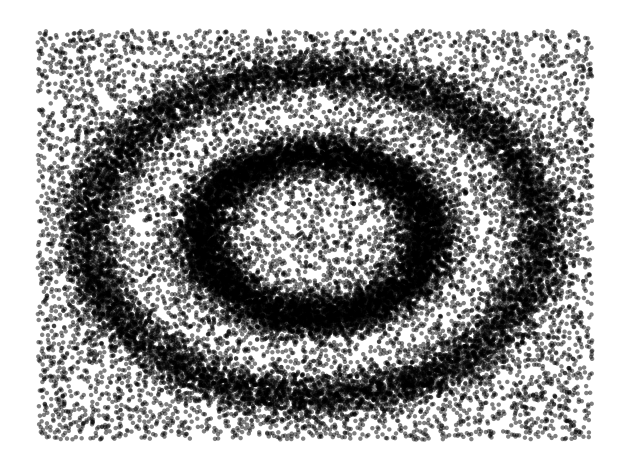

In [28]:
rng = np.random.default_rng(seed=0)
N1 = N // 2
N2 = N // 2
# M = 10_000

Z1 = sample_circle(N1, rng, r=1, std=sigma)
Z2 = sample_circle(N2, rng, r=0.5, std=sigma)
# Z3 = sample_circle(N3, rng, r=0.2, std=0.02)
Z = np.r_[Z1, Z2]

upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
# Y = sample_rectangle(M, rng)
X = np.r_[Z1, Z2, Y]
plt.scatter(*X.T, s=10, color="black", alpha=0.5, edgecolor="none")
plt.gca().axis("off")
plt.tight_layout()
plt.show()

In [29]:
%%time
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

CPU times: user 4.69 s, sys: 51.2 ms, total: 4.74 s
Wall time: 2.63 s


In [30]:
N1 = (M + N) // 2
N2 = N1
# M = 10_000

Z1 = sample_circle(N1, rng, r=1, std=0)
Z2 = sample_circle(N2, rng, r=0.5, std=0)
# Z3 = sample_circle(N3, rng, r=0.2, std=0.02)
X = np.r_[Z1, Z2]

In [31]:
%%time
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_ideal = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

CPU times: user 5.52 s, sys: 69.6 ms, total: 5.59 s
Wall time: 3.59 s


CPU times: user 546 ms, sys: 112 ms, total: 658 ms
Wall time: 449 ms


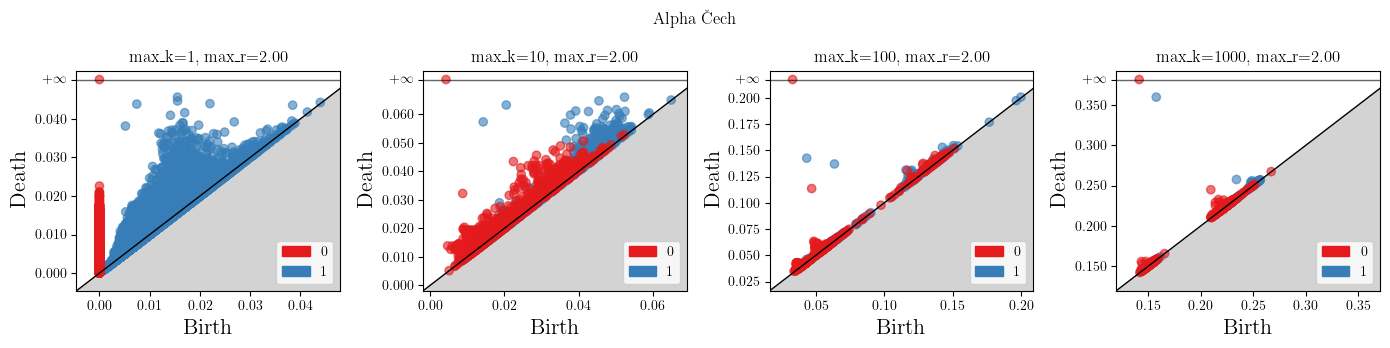

In [32]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [33]:
for dim in [0, 1]:
    np.savetxt(path + '/circles_'  + 'dim' + str(dim) + '.csv', 
            bottleneck_distances(pers_ideal, pers_diagrams, dim=dim)[None, :],
              delimiter='&',
              fmt="%.3f")

# Torus 1

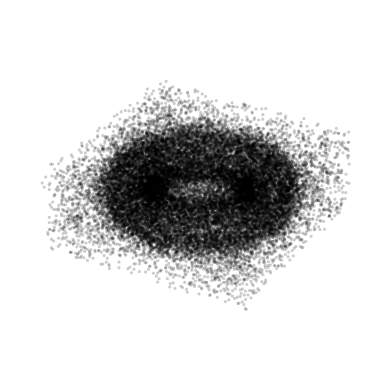

In [34]:
rng = np.random.default_rng(seed=0)
Z = sample_torus(N, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
# Y = sample_cube(M, rng, lower_left_corner=(-2, -2, -0.5), upper_right_corner=(2, 2, 0.5))
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [35]:
%%time
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
pers_ideal = [[(0, (0, np.inf)), (1, (0, 0.25)), (1, (0, 0.5)), (2, (0, 0.25))]]
# + pers_diagrams

CPU times: user 14.5 s, sys: 99.2 ms, total: 14.6 s
Wall time: 12 s


In [36]:
X = sample_torus(M + N, rng, std=0)

In [37]:
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_ideal = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

CPU times: user 1.07 s, sys: 149 ms, total: 1.22 s
Wall time: 987 ms


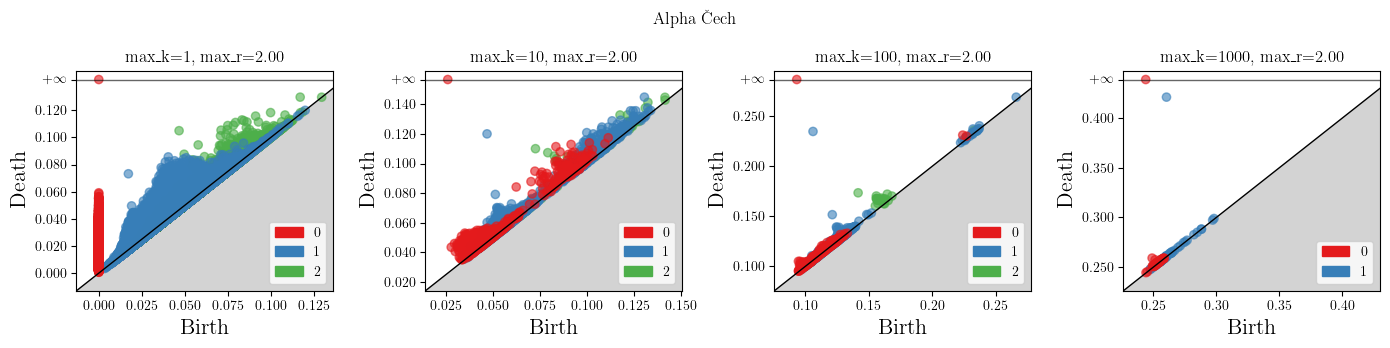

In [38]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [39]:
for dim in [0, 1, 2]:
    np.savetxt(path + '/torus_'  + 'dim' + str(dim) + '.csv', 
            bottleneck_distances(pers_ideal, pers_diagrams, dim=dim)[None, :],
              delimiter='&',
              fmt="%.3f")

# Sphere

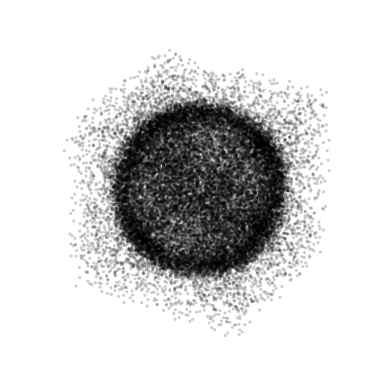

In [40]:
rng = np.random.default_rng(seed=0)
Z = sample_sphere(N, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

In [41]:
%%time
max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)
#pers_ideal = [[(0, (0, np.inf)), (2, (0, 1.))]]
# + pers_diagrams

CPU times: user 14.7 s, sys: 61.3 ms, total: 14.7 s
Wall time: 12.2 s


In [42]:
X = sample_sphere(M+N, rng, std=0)

In [43]:
pers_ideal = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

CPU times: user 938 ms, sys: 206 ms, total: 1.14 s
Wall time: 1.8 s


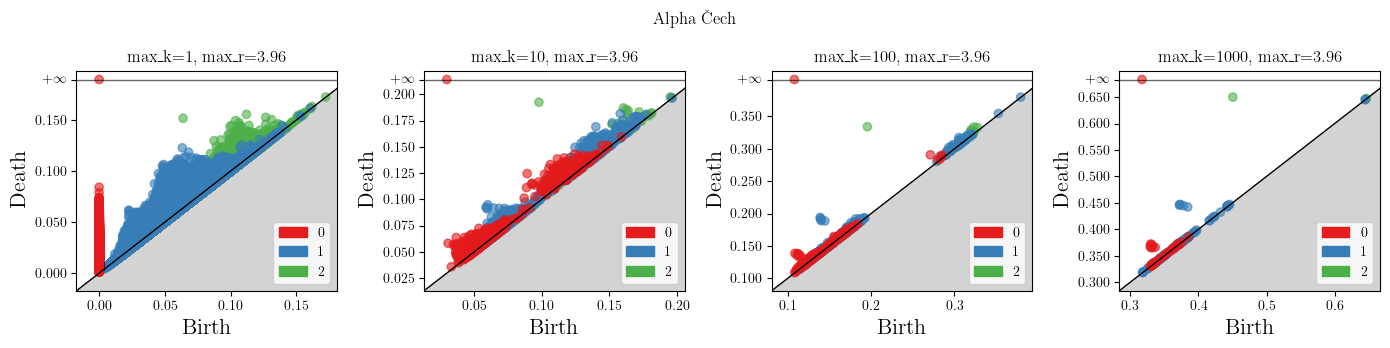

In [44]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [45]:
for dim in [0, 1, 2]:
    np.savetxt(path + '/sphere_'  + 'dim' + str(dim) + '.csv', 
            bottleneck_distances(pers_ideal, pers_diagrams, dim=dim)[None, :],
              delimiter='&',
              fmt="%.3f")

In [46]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

array([0.47647767, 0.46417398, 0.41313817, 0.27387041])

In [47]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

array([0.02974405, 0.0173636 , 0.03107421, 0.04054843])

In [48]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)

array([0.04208406, 0.01767916, 0.04003751, 0.04788152])

# Torus 2 (Clifford torus)

In [49]:
rng = np.random.default_rng(seed=0)
Z = sample_flat_torus(N, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]

In [ ]:
%%time

max_r = 2*math.sqrt(Miniball(X).squared_radius())
pers_diagrams = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

In [ ]:
X = sample_flat_torus(M+N, rng, std=0)

In [ ]:
pers_ideal = persistence_diagrams(
    X=X,
    max_ks = max_ks,
    max_r=max_r
)

In [ ]:
%%time
fig = plot_persistence_diagrams(pers_diagrams, max_ks, max_r)

In [ ]:
%%time
fig = plot_persistence_diagrams(pers_ideal, max_ks, max_r)

In [ ]:
for dim in [0, 1, 2, 3]:
    np.savetxt(path + '/clifford_torus_'  + 'dim' + str(dim) + '.csv', 
            bottleneck_distances(pers_ideal, pers_diagrams, dim=dim)[None, :],
              delimiter='&',
              fmt="%.3f")

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=3)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=2)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=1)

In [ ]:
bottleneck_distances(pers_ideal, pers_diagrams, dim=0)